In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

start_date="2012-02-01"
end_date="2016-12-31"

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [3]:
cash_ticker = "_CASH"

In [4]:
sigmas[cash_ticker] = 0.
returns = returns.rename(columns={"USDOLLAR": cash_ticker})
volumes[cash_ticker] = np.finfo(np.float).max

In [5]:
w_b = pd.Series(index=returns.columns, data=1)
w_b._CASH = 0.
w_b/=sum(w_b)


In [6]:
return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


In [7]:
sigma_estimate[cash_ticker] = 0.
return_estimate = return_estimate.rename(columns={"USDOLLAR": cash_ticker})
volume_estimate[cash_ticker] = np.finfo(np.float).max

In [8]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

simulated_hcost=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
simulated_tcost=helium.TransactionCost(gamma =1.0, 
                                             half_spread=0.0005/2,
                                             nonlin_coef = 1.,
                                             sigmas = sigmas, 
                                             nonlin_power = 1.5,
                                             volumes = volumes,
                                             asym_coef = 0.)

simulator = helium.MarketSimulator(returns, volumes, costs=[
    simulated_tcost, 
    simulated_hcost
], cash_ticker=cash_ticker)

In [9]:
deltas = return_estimate.copy()
deltas[:]  = 0.
r= helium.DefaultRet(return_estimate, deltas = deltas, gamma_decay=None)

Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

In [ ]:
policies = {}
results = {}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
            risk_model, 
                 optimization_tcost, 
                 optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

In [11]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[39.005068671695774, 38.04545423987056, 34.61200235575122, 29.033956738505502, 20.92542555935635, 11.137607903755685, 4.3423181586511586, 1.668687675653875, 0.5540503517273325] [14.808550283419496, 13.983722261898672, 10.585309629002237, 8.593923509946984, 7.52287937216698, 6.8391260944758026, 4.0134114610309295, 1.9552581333373587, 0.7176887289374069]
[36.396270875163374, 35.214305581805164, 30.829464875156244, 23.524054025778376, 13.024543885318623, 6.801001841556821, 3.113023311771244, 1.3496602930492916, 0.4890952368794945] [29.118486652301556, 26.506968041664962, 22.019391667091043, 16.092738646322495, 12.30175455974774, 7.825501967805095, 3.876358793755058, 1.7775514325420878, 0.65500054508405]
[36.47548970829659, 31.999256802020394, 20.411234021092017, 10.936237870305424, 6.033574288134635, 3.4604260349107707, 1.642307088873636, 0.7898477189393028, 0.3446121116516065] [33.84990276813219, 25.289391766536323, 10.845198046718462, 6.77836332361244, 4.664100465913707, 3.2097908882386

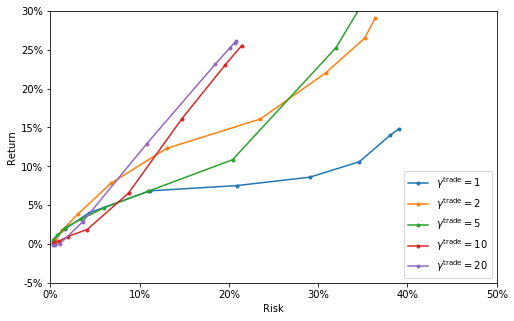

In [12]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine Search

In [ ]:
policies = {}
results = {}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
        optimization_hcost = helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)
        optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
        # issue optimization_tcost
        costs = [
            risk_model, 
                 optimization_tcost, 
                 optimization_hcost
                ]
        const = [helium.LeverageLimitConstraint(3)]
        policies[(gamma_risk, gamma_tcost)] = helium.SinglePeriodOpt(r, costs, const)
        results[(gamma_risk, gamma_tcost)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost)],
                                                         start_date, 
                                                         end_date)

In [14]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

[37.45092023000151, 33.26110941359092, 22.52653663381051, 13.204266622189174, 7.550634959761862, 4.102161819262564, 1.9181488482695388, 0.9203301354403947, 0.3836990654378211] [33.25301186324612, 24.896176064450188, 15.838772615639444, 9.82813569844642, 6.222704335505145, 4.5707308307179115, 2.663521838078213, 1.3315335982562713, 0.5250983565723509]
[36.47548970829659, 31.999256802020394, 20.411234021092017, 10.936237870305424, 6.033574288134635, 3.4604260349107707, 1.642307088873636, 0.7898477189393028, 0.3446121116516065] [33.84990276813219, 25.289391766536323, 10.845198046718462, 6.77836332361244, 4.664100465913707, 3.2097908882386625, 2.0981309301928177, 1.1048619271413957, 0.45490484781830653]
[33.866884304451894, 28.885066061274323, 18.631849451887813, 9.804002834399709, 5.0222580049786005, 2.951045252344284, 1.4518704197635852, 0.7023955204472337, 0.3134920011368585] [31.011987407897575, 23.157630720099124, 9.474135032367677, 4.872275987374867, 3.7384640288365856, 2.252343192039

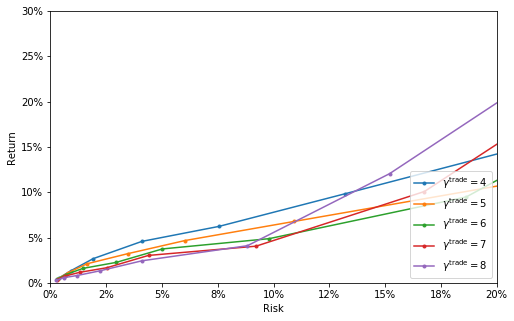

In [15]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

### Pareto

In [16]:
results_pareto={}

In [ ]:
policies = {}
#results = {}
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            risk_model = helium.BasicRiskCost(gamma_risk, Sigma_hat)
            optimization_hcost = helium.HoldingCost(gamma_holding , borrow_costs=borrow_costs, dividends=dividends)
            optimization_tcost = helium.TransactionCost(gamma_tcost, 
                                                    half_spread=0.0005/2., 
                                                    nonlin_coef = 1.,
                                                    sigmas = sigma_estimate, 
                                                    nonlin_power = 1.5,
                                                    volumes = volume_estimate,
                                                    asym_coef = 0.)
        
            # issue optimization_tcost

            costs = [risk_model,    optimization_tcost,                  optimization_hcost  ]
            const = [helium.LeverageLimitConstraint(3)]
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = helium.SinglePeriodOpt(r, costs, const)
            results_pareto[(gamma_risk, gamma_tcost, gamma_holding)] = simulator.run(1E8*w_b, 
                                                         policies[(gamma_risk, gamma_tcost, gamma_holding)],
                                                         start_date, 
                                                         end_date)

In [18]:
len(results_pareto)

408

In [19]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
#table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

/home/yowtzu/anaconda/envs/cvxportfolio/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


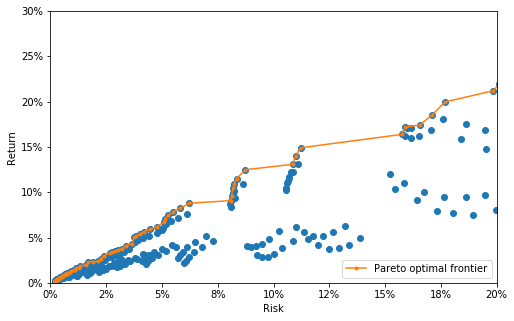

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [21]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                1000.00 &                      8.0 &                    100 &   0.17\% &   0.22\% \\
                1000.00 &                      7.5 &                    100 &   0.19\% &   0.22\% \\
                1000.00 &                      7.0 &                    100 &   0.20\% &   0.22\% \\
                1000.00 &                      6.5 &                    100 &   0.22\% &   0.22\% \\
                1000.00 &                      6.0 &                    100 &   0.24\% &   0.23\% \\
                1000.00 &                      5.5 &                    100 &   0.26\% &   0.23\% \\
                1000.00 &                      7.5 &                     10 &   0.28\% &   0.26\% \\
                1000.00 &                      7.0 &                     10 &   0.30\% &   0.27\% \\
                1000.00 &                      6.5 &

In [22]:
table.tail(50)

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
223,18.0,5.5,100,4.10%,3.38%
227,18.0,6.0,100,3.78%,3.19%
233,18.0,6.5,100,3.60%,3.03%
238,18.0,7.0,100,3.46%,2.89%
240,18.0,7.5,100,3.35%,2.76%
243,18.0,8.0,100,3.25%,2.67%
250,32.0,5.5,100,3.01%,2.39%
255,32.0,6.0,100,2.67%,2.26%
259,32.0,6.5,100,2.39%,2.16%
270,56.0,5.5,10,2.34%,1.90%
